#### Scraping Our Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
# function to scrape the data
def scraper(base_url: str, start_page: str, end_page: str) -> pd.DataFrame:
    reviews = []

    for page_num in range(start_page, end_page + 1):
        url = f"{base_url}/page/{page_num}/?sortby=post_date%3ADesc&pagesize=100"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        review_elements = soup.find_all('article', itemprop='review')

        for element in review_elements:
            review_data = {}

            # Define the verification status based on the presence of specific text
            if "✅ Trip Verified" in element.get_text():
                review_data['verification_status'] = "Trip Verified"
            elif "✅ Verified Review" in element.get_text():
                review_data['verification_status'] = "Review Verified"
            else:
                review_data['verification_status'] = "Not Verified"

            # Clean review body text
            review_body = element.find('div', class_='text_content').get_text(strip=True)
            review_body = review_body.replace("✅Trip Verified|", "").replace("✅Verified Review|", "").replace("Not Verified|", "").strip()
            review_data['review_body'] = review_body

            # Extract published date
            published_date = element.find('time', itemprop='datePublished')['datetime']
            review_data['published_date'] = published_date

            # Extract rating
            rating_element = element.find('div', itemprop='reviewRating')
            if rating_element:
                rating_value = rating_element.find('span', itemprop='ratingValue').get_text(strip=True)
                best_rating = rating_element.find('span', itemprop='bestRating').get_text(strip=True)
                review_data['rating'] = f"{rating_value}/{best_rating}"

            # Extract additional data
            rows = element.find_all('tr')
            for row in rows:
                header = row.find('td', class_='review-rating-header')
                value = row.find('td', class_='review-value')
                if header and value:
                    review_data[header.get_text(strip=True)] = value.get_text(strip=True)

            reviews.append(review_data)

    df = pd.DataFrame(reviews)
    return df

# Define the base URL and page range
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'
start_page = 1
end_page = 40

# Scrape the reviews
reviews_df = scraper(base_url, start_page, end_page)

print(reviews_df)


     verification_status                                        review_body  \
0           Not Verified  Very good flight following an equally good fli...   
1           Not Verified  An hour's delay due to late arrival of the inc...   
2          Trip Verified  I booked through BA because Loganair don’t hav...   
3          Trip Verified  British airways lost bags in LHR then found th...   
4          Trip Verified  The check in process and reward/loyalty progra...   
...                  ...                                                ...   
3906        Not Verified  Flew return in CW from LHR to BKK in August 20...   
3907        Not Verified  LHR to HAM. Purser addresses all club passenge...   
3908        Not Verified  My son who had worked for British Airways urge...   
3909        Not Verified  London City-New York JFK via Shannon on A318 b...   
3910        Not Verified  SIN-LHR BA12 B747-436 First Class. Old aircraf...   

     published_date rating Aircraft Type Of Travell

In [96]:
# save this data to the raw data folder
reviews_df.to_parquet('../data/raw/past_reviews.parquet')

In [2]:
# make sure we can read it in
reviews_df = pd.read_parquet('../data/raw/past_reviews.parquet')

In [3]:
reviews_df.head()

,verification_status,review_body,published_date,rating,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9/10,A320,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7/10,A319,Family Leisure,Economy Class,London to Lisbon,January 2025,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1/10,None,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1/10,None,Family Leisure,Premium Economy,Houston to cologne via London,December 2024,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1/10,A320,Business,Economy Class,London to Basel,January 2025,no


### EDA 

It appears that all of our data are **object** types but the rating should be a numeric value. We also see that some of the columns are capital and include spaces from when we scraped the data table and the variables we created are lowercase with underscores so we can change them to a standard format.

In [4]:
# function to rename columns
def rename_cols(reviews_df: pd.DataFrame) -> pd.DataFrame:
    '''Change column names to snake case.'''
    return reviews_df.rename(columns={
        'Aircraft': 'aircraft',
        'Type Of Traveller': 'type_of_traveler', 
        'Seat Type': 'seat_type', 
        'Route': 'route', 
        'Date Flown': 'date_flown', 
        'Recommended': 'recommended'},
        inplace=True
)

In [5]:
# rename the columns using the function
rename_cols(reviews_df)

In [6]:
# check they have been renamed
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   verification_status  3911 non-null   object
 1   review_body          3911 non-null   object
 2   published_date       3911 non-null   object
 3   rating               3906 non-null   object
 4   aircraft             2037 non-null   object
 5   type_of_traveler     3140 non-null   object
 6   seat_type            3909 non-null   object
 7   route                3135 non-null   object
 8   date_flown           3133 non-null   object
 9   recommended          3911 non-null   object
dtypes: object(10)
memory usage: 305.7+ KB


In [7]:
reviews_df.describe()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
count,3911,3911,3911,3906,2037,3140,3909,3135,3133,3911
unique,3,3896,1981,10,212,4,4,1633,126,2
top,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-01-19,1/10,A320,Couple Leisure,Economy Class,London to Johannesburg,August 2015,no
freq,1837,2,26,951,394,1057,2038,21,83,2354


In [8]:
reviews_df['verification_status'].value_counts()

verification_status
Not Verified       1837
Trip Verified      1304
Review Verified     770
Name: count, dtype: int64

#### Route and Date Flown

We have the **published_date** which we will use as the date in our analysis so we can remove the **date_flown** column from the data. We can also remove **route** since there are 1633 unique values here.

In [9]:
reviews_df.drop(columns=['route', 'date_flown'], axis=1, inplace=True)

The **review_body** column has 3911 reviews but only 3896 unique values meaning we have duplicates. We can inspect and remove them.

In [10]:
# find the duplicate reviews and inspect them
duplicate_review_body = reviews_df[reviews_df.duplicated(subset=['review_body'], keep=False)]
duplicate_review_body.sort_values('review_body')

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
3596,Not Verified,BA26 22/6/2014. During my trip to the UK I fee...,2014-10-05,7/10,None,None,Economy Class,yes
3603,Not Verified,BA26 22/6/2014. During my trip to the UK I fee...,2014-10-05,7/10,None,None,Economy Class,yes
3400,Not Verified,BA284 Dec 29 2014. SFO-LHR First. Great flight...,2015-01-19,10/10,None,None,First Class,yes
3393,Not Verified,BA284 Dec 29 2014. SFO-LHR First. Great flight...,2015-01-19,10/10,None,None,First Class,yes
2739,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-12-01,8/10,Boeing 777,Couple Leisure,Business Class,yes
2767,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-11-20,8/10,Boeing 777,Couple Leisure,Business Class,yes
3200,Not Verified,CPT-LHR-MAD in club. Check-in in CPT quick and...,2015-05-16,9/10,None,None,Business Class,yes
3199,Not Verified,CPT-LHR-MAD in club. Check-in in CPT quick and...,2015-05-16,9/10,None,None,Business Class,yes
3604,Not Verified,Flew the new 787 Business Class from PHI to LH...,2014-10-05,6/10,None,None,Business Class,no
3597,Not Verified,Flew the new 787 Business Class from PHI to LH...,2014-10-05,6/10,None,None,Business Class,no


In [11]:
print(len(duplicate_review_body))

30


When we check the duplicates for the entire dataset we are getting a number smaller (26) than our number for the reviews (30). After inspection, we see that these reviews came in on different dates so that is the reason there are less for the entire dataset. Having a different date posted causes them not to be duplicates. We will remove the duplicates and keep the one with the oldest date. When we scraped the data we were using their filter which had them sorted by date from newest to oldest so we will sort them from oldest to newest to keep the oldest duplicate.

In [12]:
# Identify duplicate rows based on the entire dataset
duplicate_rows = reviews_df[reviews_df.duplicated(keep=False)]

# Display the duplicate rows
print(len(duplicate_rows))


26


In [13]:
# remove duplicates and keep the oldest review - sort by published date
reviews_df['published_date'] = pd.to_datetime(reviews_df['published_date'])
# sort by published date
reviews_df.sort_values('published_date', inplace=True)
# remove duplicates
reviews_df.drop_duplicates(subset='review_body', keep='first', inplace=True)


In [14]:
# now there should be 3904 reviews since there were 3904 unique reviews
len(reviews_df)

3896

In [15]:
# sort by published date with most recent being first
reviews_df.sort_values('published_date', ascending=False, inplace=True) 
reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9/10,A320,Solo Leisure,Business Class,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7/10,A319,Family Leisure,Economy Class,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1/10,None,Solo Leisure,Economy Class,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1/10,None,Family Leisure,Premium Economy,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1/10,A320,Business,Economy Class,no


In [16]:
# reset the index
reviews_df.reset_index(drop=True, inplace=True)

In [17]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896 entries, 0 to 3895
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   verification_status  3896 non-null   object        
 1   review_body          3896 non-null   object        
 2   published_date       3896 non-null   datetime64[ns]
 3   rating               3891 non-null   object        
 4   aircraft             2035 non-null   object        
 5   type_of_traveler     3138 non-null   object        
 6   seat_type            3894 non-null   object        
 7   recommended          3896 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 243.6+ KB


In [18]:
reviews_df.describe(include='all')

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
count,3896,3896,3896,3891,2035,3138,3894,3896
unique,3,3896,NaN,10,212,4,4,2
top,Not Verified,SIN-LHR BA12 B747-436 First Class. Old aircraf...,NaN,1/10,A320,Couple Leisure,Economy Class,no
freq,1822,1,NaN,949,394,1055,2035,2349
mean,NaN,NaN,2018-02-02 17:50:23.408624128,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2011-10-09 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2015-09-19 00:00:00,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2017-04-09 00:00:00,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2019-09-16 00:00:00,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN


The rating column are reviews based on a scale from 1-10 so we can convert this to a numeric value, however, there are some missing values (5) so we will have to check these out first.

#### Rating Variable

In [19]:
# Filter the DataFrame to find rows with NaN values in the 'review' column
nan_reviews = reviews_df[reviews_df['rating'].isna()]
nan_reviews

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
3338,Not Verified,Cabin crew polite unfortunately BA ran out of ...,2015-02-18,None,None,None,Economy Class,no
3457,Not Verified,Phoenix to London - outbound a wonderful and e...,2014-12-10,None,None,None,First Class,no
3475,Not Verified,On past experience I chose BA for our long hau...,2014-11-25,None,None,None,Economy Class,no
3708,Not Verified,LHR-CPH-LHR Business Class. This is a joke. Sc...,2014-07-31,None,None,None,Business Class,no
3738,Not Verified,I flew with British Airways with my mother fro...,2014-07-15,None,None,None,Economy Class,no


Although there are NaN values for the following 5 reviews we can see that they are all bad reviews. This means we can inpute a value here knowing that the review would not be plesent. Looking at the **value_counts** for the ratings most ratings are 1/10 and these ratings seem to fit a 1/10 rating as well so we will impute that value for them.

In [20]:
for review in nan_reviews['review_body']:
    print(f'{review}\n')

Cabin crew polite unfortunately BA ran out of chicken ran out of wine ran out of soft drinks. The food was awful. Inflight service was a disaster - did not work properly. 12 hours 20 mins flight everything counts obviously BA overlooked this. To be fair all cabin crew were polite and accommodating. I will never fly again with BA.

Phoenix to London - outbound a wonderful and enjoyable experience. The problem we had started on our return flight home. We boarded the plane and were disappointed to find out that we were in the old style first class. After being in the new cabin on the way out the old configuration is very run down and there was a rip in the seat. I was attempting to work but when I went to plug in my laptop battery I found that there was no adapter for me to use. Since I could no longer work I decided to put a movie on. The tiny screen in the old first class was just pathetic. The flight attendants did their absolute best to make up for the issues and I give them high mark

In [21]:
reviews_df['rating'].value_counts()

rating
1/10     949
2/10     444
3/10     429
8/10     385
10/10    334
9/10     323
7/10     321
4/10     262
5/10     243
6/10     201
Name: count, dtype: int64

In [22]:
# fill the empty ratings with a 1/10
reviews_df['rating'] = reviews_df['rating'].fillna('1/10')

In [23]:
# no more missing values
reviews_df[reviews_df['rating'].isna()]

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended


In [24]:
reviews_df['rating'].value_counts()

rating
1/10     954
2/10     444
3/10     429
8/10     385
10/10    334
9/10     323
7/10     321
4/10     262
5/10     243
6/10     201
Name: count, dtype: int64

In [25]:
# Function to convert rating to float
def convert_rating(rating: str) -> float:
    '''Convert rating to float.'''
    # Split the string on '/' and take the first part
    numerator = rating.split('/')[0]  
    return float(numerator)

# Apply the function to the 'rating' column
reviews_df['rating'] = reviews_df['rating'].apply(convert_rating)

reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9.0,A320,Solo Leisure,Business Class,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7.0,A319,Family Leisure,Economy Class,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,no


In [26]:
(reviews_df['rating']).describe()

count    3896.000000
mean        4.664271
std         3.175115
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        10.000000
Name: rating, dtype: float64

#### Verification Status

In [27]:
# mean rating per verification status
reviews_df.groupby('verification_status')['rating'].mean()

verification_status
Not Verified       5.235456
Review Verified    4.090909
Trip Verified      4.204755
Name: rating, dtype: float64

In [28]:
# verification status counts normalized
reviews_df['verification_status'].value_counts(normalize=True)

verification_status
Not Verified       0.467659
Trip Verified      0.334702
Review Verified    0.197639
Name: proportion, dtype: float64

In [29]:
# plot the ratings by year
reviews_df['year'] = reviews_df['published_date'].dt.year
reviews_df['month'] = reviews_df['published_date'].dt.month
reviews_df['day'] = reviews_df['published_date'].dt.day


#### Publication Date

On average, about 2 reviews are posted on the same day. We also see that the number of reviews posted have decreased after a boom in 2014. This also happens to be the year where the average rating was the highest. Overtime, the ratings have diminished from a max of 6.2 to the current value of 4.7. This year has the smallest average rating but only has a total of 8 reviews thus far so we cannot say too much about it. If we look back one year to 2024, we made improvements on 2023, but the average rating was still down from previous years.

In [30]:
reviews_df['year'].value_counts() 

year
2015    733
2017    572
2016    570
2014    459
2019    356
2018    324
2023    280
2022    213
2024    176
2020    104
2021     87
2012     11
2025      8
2011      3
Name: count, dtype: int64

In [31]:
# publication date counts
publication_date_counts = reviews_df['published_date'].dt.date.value_counts().sort_index()
publication_date_counts.mean()

np.float64(1.96668349318526)

In [32]:
# plot the publication date counts using plotly line plot
fig = px.line(publication_date_counts, title='Publication Date Counts')
fig.update_xaxes(title_text='Date')


In [33]:
# get the averages for each year
def yearly_avg(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to return the yearly average rating.'''
    return df.groupby('year')['rating'].mean().reset_index()



In [34]:
reviews_df['year'].value_counts()

year
2015    733
2017    572
2016    570
2014    459
2019    356
2018    324
2023    280
2022    213
2024    176
2020    104
2021     87
2012     11
2025      8
2011      3
Name: count, dtype: int64

There are no reviews during 2013. I double checked the website and this is true on the website as well.

In [35]:
# get the yearly averages
yearly = yearly_avg(reviews_df)
# plot using plotly bar plot
fig = px.bar(
            yearly,
            x='year',
            y='rating', 
            title='Average Rating by Year'
)
fig.show()

In [36]:
# Sort by 'published_date'
reviews_df = reviews_df.sort_values('published_date')

# Calculate cumulative average rating
reviews_df['cumulative_avg_rating'] = reviews_df['rating'].expanding().mean()

# Use Plotly to graph
fig = px.line(
    reviews_df, 
    x='published_date', 
    y='cumulative_avg_rating',
    title='Cumulative Average Rating Over Time'
)

# Show the figure
fig.show()


In [37]:
reviews_df['cumulative_avg_rating'].max()

np.float64(6.218181818181818)

#### Customer Type

In [38]:
# plot ratings by customer type
fig = px.box(reviews_df, x='type_of_traveler', y='rating', title='Ratings by Customer Type')
fig.show()

In [39]:
reviews_df.sort_values('published_date', ascending=False, inplace=True)

In [40]:
reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended,year,month,day,cumulative_avg_rating
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9.0,A320,Solo Leisure,Business Class,yes,2025,1,20,4.664271
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7.0,A319,Family Leisure,Economy Class,yes,2025,1,19,4.663158
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,no,2025,1,15,4.662558
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,no,2025,1,9,4.663499
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,no,2025,1,5,4.664440


In [41]:
# sort by aircraft and get rating average
aircraft_avg = reviews_df.groupby('aircraft')['rating'].mean().sort_values(ascending=False)

In [42]:
reviews_df['aircraft'].value_counts()   

aircraft
A320              394
Boeing 777        286
Boeing 747-400    181
A380              179
Boeing 777-200    129
                 ... 
777-200             1
boeing 787          1
Airbus 319          1
777-300             1
B747                1
Name: count, Length: 212, dtype: int64

#### Seat Type

In [43]:
# seat type and rating
seat_avg = reviews_df.groupby('seat_type')['rating'].mean().sort_values(ascending=False)

In [44]:
seat_avg

seat_type
First Class        5.986301
Business Class     5.094220
Premium Economy    4.803714
Economy Class      4.231450
Name: rating, dtype: float64

#### Recommended

<Axes: xlabel='recommended'>

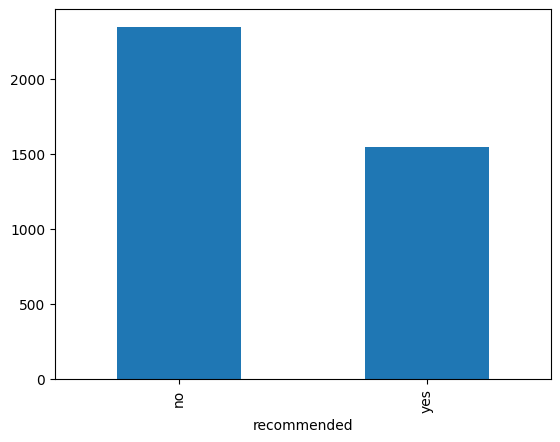

In [45]:
reviews_df['recommended'].value_counts().plot(kind='bar')

In [46]:
# Create a count plot using Plotly
fig = px.histogram(
    reviews_df, 
    x='rating', 
    color='recommended', 
    barmode='group',
    histfunc='count',
    title='Count of Recommendations by Rating'
)

# Customize the layout
fig.update_layout(
    xaxis_title='Rating',
    yaxis_title='Count',
    legend_title='Recommend'
)

# Show the figure
fig.show()


Add a plot or graph or table or print statement where we can see the percentage of each rating that answered no and yes

In [47]:
contingency_table = pd.crosstab(reviews_df['rating'], reviews_df['recommended'])
contingency_table

recommended,no,yes
rating,,
1.0,949,5
2.0,439,5
3.0,423,6
4.0,245,17
5.0,181,62
6.0,63,138
7.0,34,287
8.0,12,373
9.0,1,322


The rankings of 5 and 6 seem to be somewhat split but anything below a 5 is **not recommended** and anything above a 6 is **recommended**. We can use recommended as a target variable for our sentiment analysis. When we look at the value counts per rating, we can change anything below a 5 to be **not recommended** and anything above a 6 to be **recommended** and leave the 5 and 6 ratings as is since they are somewhat split. There were 5 people who reported a yes for recommended even though they gave it a 1 rating and 2 people would not recommend even though they gave it a 10 rating. These can be reporting errors since they do not reflect one another. 

In [48]:
normalized = pd.crosstab(reviews_df['rating'], reviews_df['recommended'], normalize='index')
normalized

recommended,no,yes
rating,,
1.0,0.994759,0.005241
2.0,0.988739,0.011261
3.0,0.986014,0.013986
4.0,0.935115,0.064885
5.0,0.744856,0.255144
6.0,0.313433,0.686567
7.0,0.105919,0.894081
8.0,0.031169,0.968831
9.0,0.003096,0.996904


As we would expect, there is a high correlation between the rating and the recommended variables. 

In [49]:
recommended_num = reviews_df.copy()

# Convert 'recommended' to numeric
recommended_num['recommended_numeric'] = recommended_num['recommended'].apply(lambda x: 1 if x == 'yes' else 0)

# Calculate the correlation
correlation = recommended_num[['rating', 'recommended_numeric']].corr().iloc[0, 1]

print("Correlation between Rating and Recommended:", correlation)


Correlation between Rating and Recommended: 0.8649167886085368


In [50]:
reviews_df

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended,year,month,day,cumulative_avg_rating
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9.0,A320,Solo Leisure,Business Class,yes,2025,1,20,4.664271
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7.0,A319,Family Leisure,Economy Class,yes,2025,1,19,4.663158
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,no,2025,1,15,4.662558
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,no,2025,1,9,4.663499
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,no,2025,1,5,4.664440
...,...,...,...,...,...,...,...,...,...,...,...,...
3883,Not Verified,This was a bmi Regional operated flight on a R...,2012-08-29,1.0,None,None,Economy Class,no,2012,8,29,4.666667
3892,Not Verified,LHR to HAM. Purser addresses all club passenge...,2012-08-28,9.0,None,None,Business Class,yes,2012,8,28,5.500000
3893,Not Verified,My son who had worked for British Airways urge...,2011-10-12,5.0,None,None,Economy Class,yes,2011,10,12,4.333333
3894,Not Verified,London City-New York JFK via Shannon on A318 b...,2011-10-11,4.0,None,None,Premium Economy,no,2011,10,11,4.000000


In [51]:
monthly_avg = reviews_df.groupby('month')['rating'].mean().reset_index()
monthly_avg

,month,rating
0,1,4.696793
1,2,4.691304
2,3,4.436620
3,4,4.651316
4,5,5.082353
5,6,4.580645
6,7,4.373089
7,8,4.658307
8,9,4.596439
9,10,4.723077


In [52]:
#months do not matter
fig = px.bar(
    monthly_avg,
    x='month',
    y='rating',
    title='Average Rating by Month'
)
fig.show()

In [53]:
# Concatenate all reviews into a single string
all_reviews = ' '.join(reviews_df['review_body'].tolist())

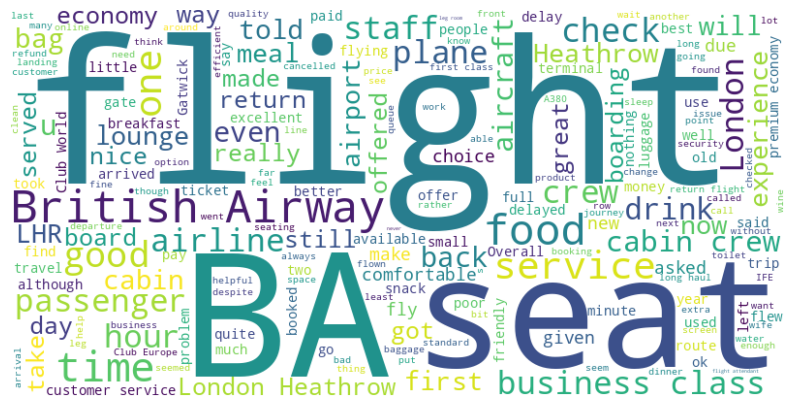

In [54]:
from wordcloud import WordCloud
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_reviews)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


This wordcloud doesn't do us much good so we can split the reviews by recommended or not.

In [55]:
# not recommended
not_recommended = reviews_df[reviews_df['recommended']== 'no']
not_recommended

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended,year,month,day,cumulative_avg_rating
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,no,2025,1,15,4.662558
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,no,2025,1,9,4.663499
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,no,2025,1,5,4.664440
5,Trip Verified,"We flew in November 2023, but it took this lon...",2025-01-04,1.0,None,Family Leisure,Economy Class,no,2025,1,4,4.665382
6,Trip Verified,I left for London from Johannesburg at 21:15 o...,2025-01-03,1.0,None,Family Leisure,Economy Class,no,2025,1,3,4.666324
...,...,...,...,...,...,...,...,...,...,...,...,...
3889,Not Verified,Flight from Heathrow to Toronto. Booked emerge...,2012-08-29,7.0,None,None,Economy Class,no,2012,8,29,5.083333
3886,Not Verified,LHR-HKG on Boeing 747 - 23/08/12. Much has bee...,2012-08-29,4.0,None,None,Economy Class,no,2012,8,29,5.000000
3883,Not Verified,This was a bmi Regional operated flight on a R...,2012-08-29,1.0,None,None,Economy Class,no,2012,8,29,4.666667
3894,Not Verified,London City-New York JFK via Shannon on A318 b...,2011-10-11,4.0,None,None,Premium Economy,no,2011,10,11,4.000000


In [56]:
not_recommended.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, 2 to 3895
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   verification_status    2349 non-null   object        
 1   review_body            2349 non-null   object        
 2   published_date         2349 non-null   datetime64[ns]
 3   rating                 2349 non-null   float64       
 4   aircraft               1090 non-null   object        
 5   type_of_traveler       2024 non-null   object        
 6   seat_type              2347 non-null   object        
 7   recommended            2349 non-null   object        
 8   year                   2349 non-null   int32         
 9   month                  2349 non-null   int32         
 10  day                    2349 non-null   int32         
 11  cumulative_avg_rating  2349 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(3), object(6)
memory usage:

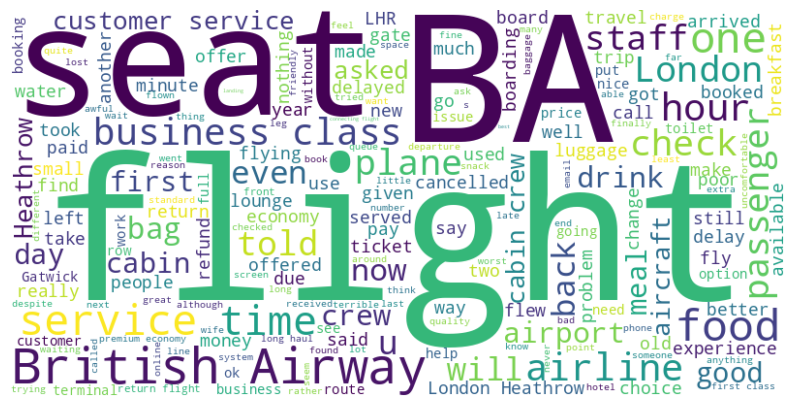

In [57]:
# wordcloud for not recommended reviews
not_recommended_reviews = ' '.join(not_recommended['review_body'].tolist())
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(not_recommended_reviews)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

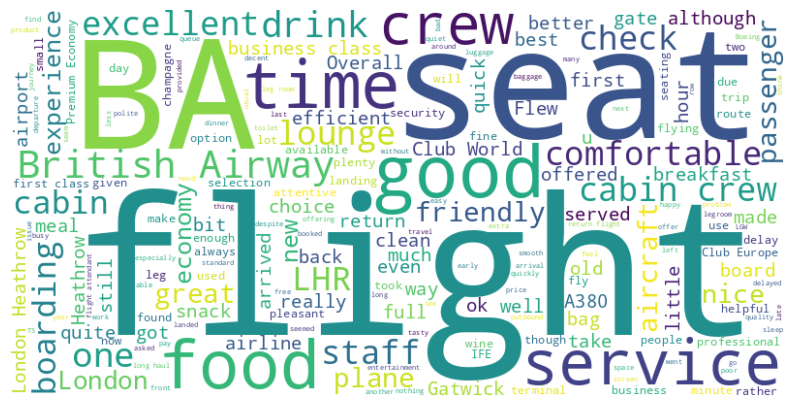

In [58]:
# same thing for recommended reviews
recommended = reviews_df[reviews_df['recommended']== 'yes']
# Concatenate all reviews into a single string
recommended_reviews = ' '.join(recommended['review_body'].tolist())
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(recommended_reviews)
# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()